# Self made RP3-beta

In [1]:
import helpers
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from collections import defaultdict
from itertools import chain
import random
import time
import matplotlib.pyplot as plt

train_read = pd.read_csv("./Datasets/ml-100k/train.csv", sep="\t", header=None)
test_read = pd.read_csv("./Datasets/ml-100k/test.csv", sep="\t", header=None)
(
    train_ui,
    test_ui,
    user_code_id,
    user_id_code,
    item_code_id,
    item_id_code,
) = helpers.data_to_csr(train_read, test_read)

In [2]:
class RP3Beta:
    def fit(self, train_ui, alpha, beta):
        """We weight our edges by user's explicit ratings so if user rated movie high we'll follow that path
        with higher probability."""
        self.train_ui = train_ui
        self.train_iu = train_ui.transpose()

        self.alpha = alpha
        self.beta = beta

        # Define Pui
        Pui = sparse.csr_matrix(self.train_ui / self.train_ui.sum(axis=1))

        # Define Piu
        to_divide = np.vectorize(lambda x: x if x > 0 else 1)(
            self.train_iu.sum(axis=1)
        )  # to avoid dividing by zero
        Piu = sparse.csr_matrix(self.train_iu / to_divide)
        item_orders = (self.train_ui > 0).sum(axis=0)

        Pui = Pui.power(self.alpha)
        Piu = Piu.power(self.alpha)

        P3 = Pui * Piu * Pui

        P3 /= np.power(
            np.vectorize(lambda x: x if x > 0 else 1)(item_orders), self.beta
        )

        self.estimations = np.array(P3)

    def recommend(self, user_code_id, item_code_id, topK=10):

        top_k = defaultdict(list)
        for nb_user, user in enumerate(self.estimations):

            user_rated = self.train_ui.indices[
                self.train_ui.indptr[nb_user] : self.train_ui.indptr[nb_user + 1]
            ]
            for item, score in enumerate(user):
                if item not in user_rated and not np.isnan(score):
                    top_k[user_code_id[nb_user]].append((item_code_id[item], score))
        result = []
        # Let's choose k best items in the format: (user, item1, score1, item2, score2, ...)
        for uid, item_scores in top_k.items():
            item_scores.sort(key=lambda x: x[1], reverse=True)
            result.append([uid] + list(chain(*item_scores[:topK])))
        return result

    def estimate(self, user_code_id, item_code_id, test_ui):
        result = []
        for user, item in zip(*test_ui.nonzero()):
            result.append(
                [
                    user_code_id[user],
                    item_code_id[item],
                    self.estimations[user, item]
                    if not np.isnan(self.estimations[user, item])
                    else 1,
                ]
            )
        return result

In [3]:
model = RP3Beta()
model.fit(train_ui, alpha=1, beta=0)

In [4]:
top_n = pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))

top_n.to_csv(
    "Recommendations generated/ml-100k/Self_P3_reco.csv", index=False, header=False
)

estimations = pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
estimations.to_csv(
    "Recommendations generated/ml-100k/Self_P3_estimations.csv",
    index=False,
    header=False,
)

In [5]:
import evaluation_measures as ev

estimations_df = pd.read_csv(
    "Recommendations generated/ml-100k/Self_P3_estimations.csv", header=None
)
reco = np.loadtxt("Recommendations generated/ml-100k/Self_P3_reco.csv", delimiter=",")

ev.evaluate(
    test=pd.read_csv("./Datasets/ml-100k/test.csv", sep="\t", header=None),
    estimations_df=estimations_df,
    reco=reco,
    super_reactions=[4, 5],
)

943it [00:00, 8787.46it/s]


RMSE       MAE  precision    recall       F_1     F_05  \
0  3.702446  3.527273   0.282185  0.192092  0.186749  0.21698   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.204185      0.240096  0.339114  0.204905  0.572157  0.593544   

         HR  Reco in test  Test coverage   Shannon      Gini  
0  0.875928           1.0       0.077201  3.875892  0.974947

# Let's check hyperparameters

##### Alpha

In [6]:
from tqdm import tqdm

result = []
for alpha in tqdm([round(i, 1) for i in np.arange(0.2, 1.6001, 0.2)]):
    model = RP3Beta()
    model.fit(train_ui, alpha=alpha, beta=0)
    reco = pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))
    estimations_df = pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
    to_append = ev.evaluate(
        test=pd.read_csv("./Datasets/ml-100k/test.csv", sep="\t", header=None),
        estimations_df=estimations_df,
        reco=np.array(reco),
        super_reactions=[4, 5],
    )
    to_append.insert(0, "Alpha", alpha)
    result.append(to_append)

result = pd.concat(result)
result

  0%|          | 0/8 [00:00<?, ?it/s]
943it [00:00, 9826.90it/s]
 12%|█▎        | 1/8 [00:07<00:55,  7.93s/it]
0it [00:00, ?it/s]
943it [00:00, 8050.54it/s]
 25%|██▌       | 2/8 [00:15<00:47,  7.94s/it]
943it [00:00, 9441.40it/s]
 38%|███▊      | 3/8 [00:24<00:40,  8.01s/it]
943it [00:00, 9745.57it/s]
 50%|█████     | 4/8 [00:32<00:32,  8.13s/it]
943it [00:00, 10134.88it/s]
 62%|██████▎   | 5/8 [00:40<00:23,  7.98s/it]
943it [00:00, 10252.12it/s]
 75%|███████▌  | 6/8 [00:47<00:15,  7.94s/it]
943it [00:00, 9769.78it/s]
 88%|████████▊ | 7/8 [00:55<00:07,  7.97s/it]
0it [00:00, ?it/s]
943it [00:00, 8272.37it/s]
100%|██████████| 8/8 [01:03<00:00,  7.99s/it]


Alpha        RMSE         MAE  precision    recall       F_1      F_05  \
0    0.2  268.177832  211.732649   0.262672  0.166858  0.166277  0.197184   
0    0.4   10.546689    7.792373   0.268505  0.172669  0.171569  0.202643   
0    0.6    3.143988    2.948790   0.274655  0.180502  0.177820  0.208730   
0    0.8    3.670728    3.495735   0.281972  0.189868  0.185300  0.216071   
0    1.0    3.702446    3.527273   0.282185  0.192092  0.186749  0.216980   
0    1.2    3.704441    3.529251   0.280912  0.193633  0.187311  0.216872   
0    1.4    3.704580    3.529388   0.273595  0.190651  0.183874  0.212183   
0    1.6    3.704591    3.529399   0.263097  0.186255  0.178709  0.205170   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.187661      0.203252  0.320910  0.196132  0.563378  0.580866   
0         0.192489      0.212653  0.326760  0.200172  0.565148  0.583801   
0         0.198176      0.222746  0.332872  0.203290  0.568872  0.587738   
0         0.203541      0.236751  0.339867  0.206688  0.573729  0.592432   
0         0.204185      0.240096  0.339114  0.204905  0.572157  0.593544   
0         0.203004      0.240588  0.338049  0.203453  0.571830  0.594313   
0         0.199464      0.239118  0.329550  0.195433  0.566171  0.592793   
0         0.191094      0.232920  0.317439  0.184917  0.552349  0.590545   

         HR  Reco in test  Test coverage   Shannon      Gini  
0  0.850477      1.000000       0.060606  3.669627  0.979636  
0  0.854719      1.000000       0.064214  3.726996  0.978426  
0  0.870626      1.000000       0.065657  3.785282  0.977090  
0  0.874867      1.000000       0.070707  3.832415  0.975998  
0  0.875928      1.000000       0.077201  3.875892  0.974947  
0  0.883351      1.000000       0.085859  3.910718  0.974073  
0  0.871686      1.000000       0.107504  3.961915  0.972674  
0  0.868505      0.999576       0.156566  4.060156  0.969203

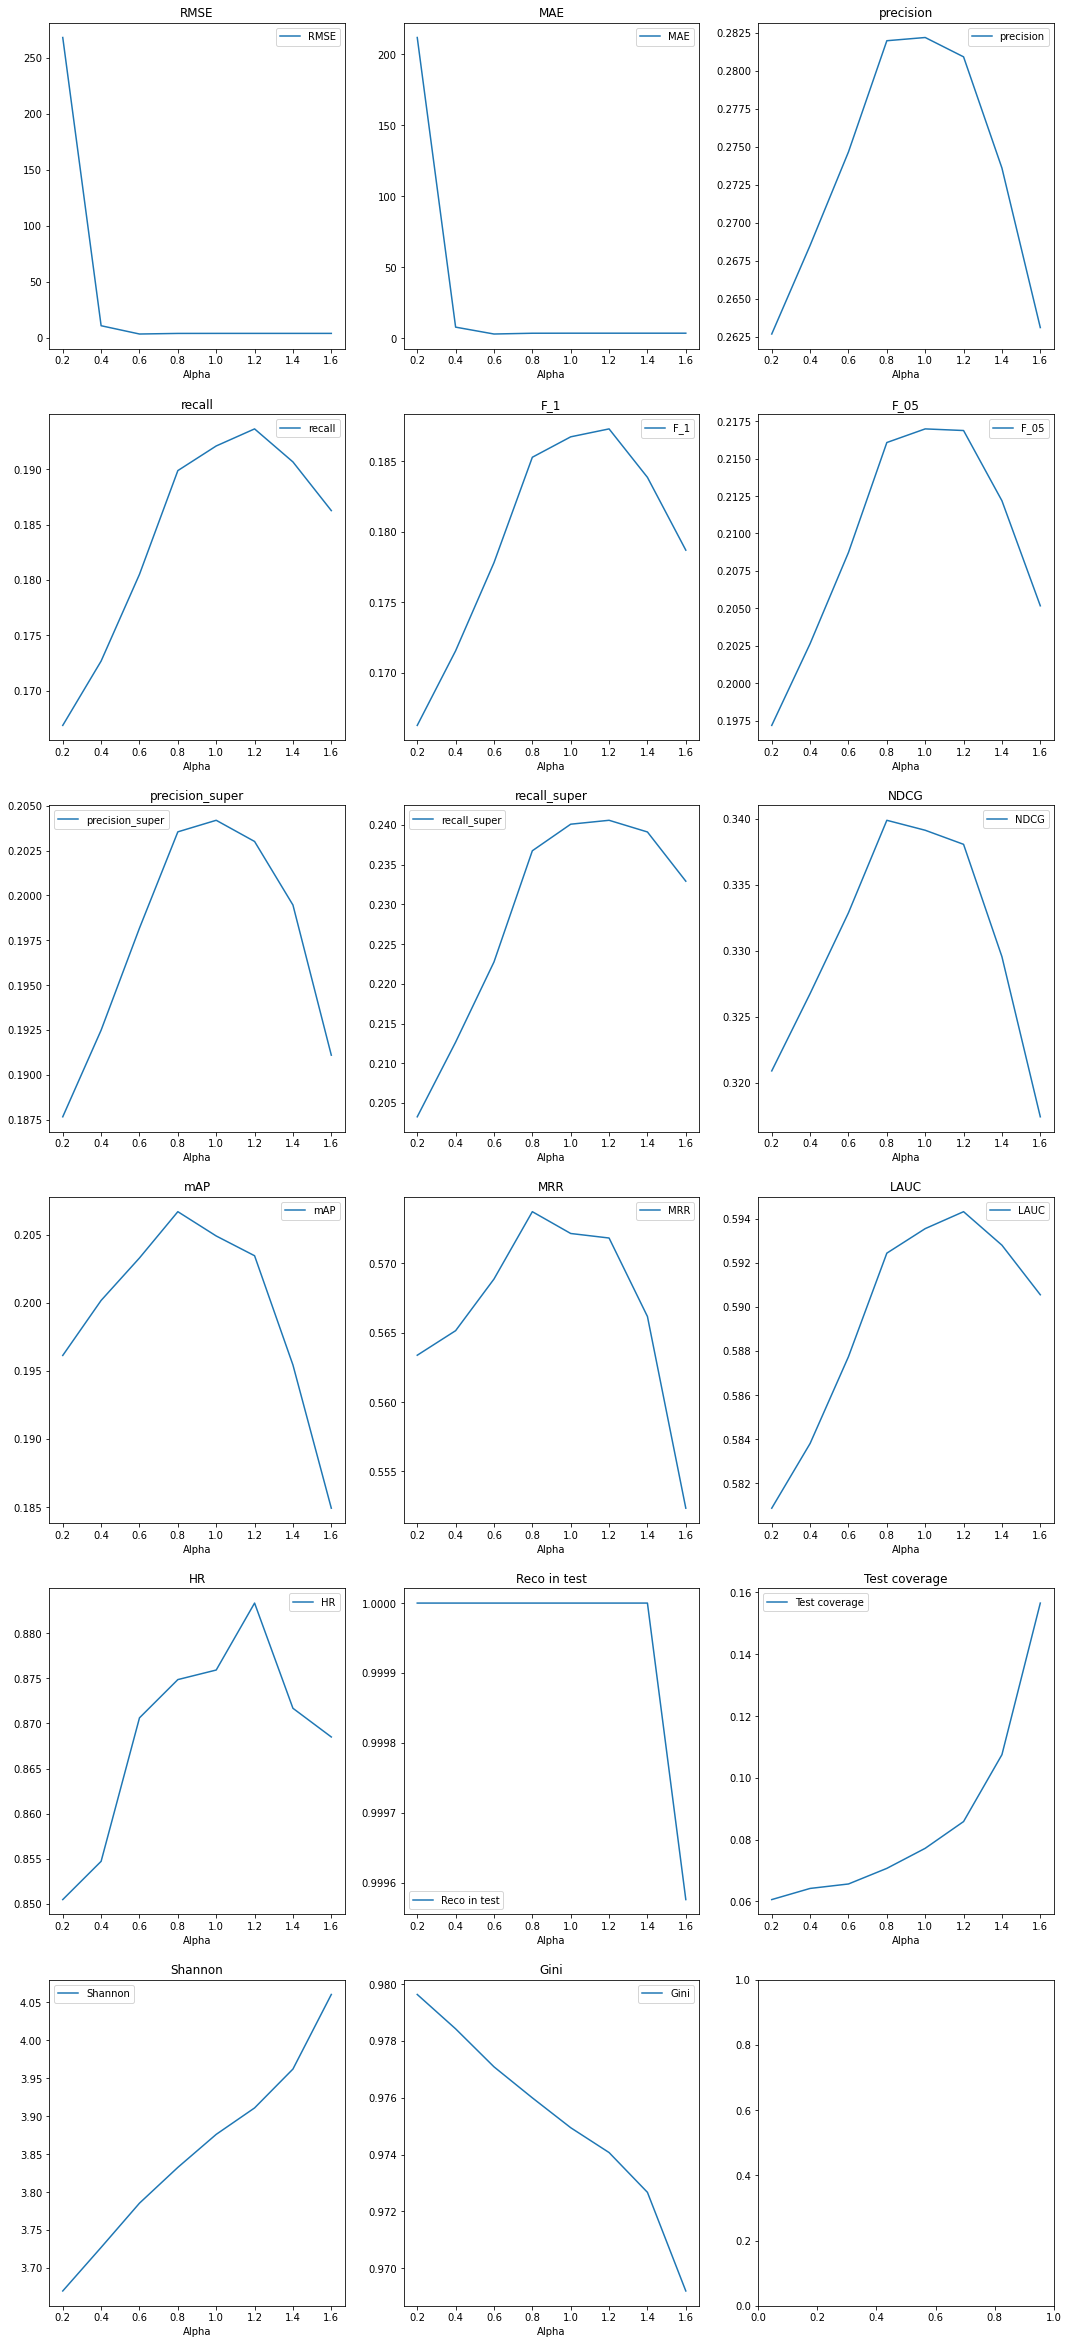

In [7]:
metrics = list(result.columns[[i not in ["Alpha"] for i in result.columns]])

charts_per_row = 6
charts_per_column = 3

fig, axes = plt.subplots(
    nrows=charts_per_row, ncols=charts_per_column, figsize=(18, 7 * charts_per_row)
)
import itertools

to_iter = [
    i for i in itertools.product(range(charts_per_row), range(charts_per_column))
]

for i in range(len(metrics)):
    df = result[["Alpha", metrics[i]]]
    df.plot(ax=axes[to_iter[i]], title=metrics[i], x=0, y=1)

##### Beta

In [8]:
from tqdm import tqdm

result = []
for beta in tqdm([round(i, 1) for i in np.arange(0, 1, 0.1)]):
    model = RP3Beta()
    model.fit(train_ui, alpha=1, beta=beta)
    reco = pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))
    estimations_df = pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
    to_append = ev.evaluate(
        test=pd.read_csv("./Datasets/ml-100k/test.csv", sep="\t", header=None),
        estimations_df=estimations_df,
        reco=np.array(reco),
        super_reactions=[4, 5],
    )
    to_append.insert(0, "Beta", beta)
    result.append(to_append)

result = pd.concat(result)
result

  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
943it [00:00, 8133.31it/s]
 10%|█         | 1/10 [00:08<01:19,  8.87s/it]
0it [00:00, ?it/s]
943it [00:00, 8733.83it/s]
 20%|██        | 2/10 [00:17<01:10,  8.81s/it]
943it [00:00, 9872.77it/s]
 30%|███       | 3/10 [00:25<01:00,  8.61s/it]
943it [00:00, 10989.65it/s]
 40%|████      | 4/10 [00:33<00:50,  8.36s/it]
943it [00:00, 10108.59it/s]
 50%|█████     | 5/10 [00:41<00:40,  8.15s/it]
943it [00:00, 9989.31it/s]
 60%|██████    | 6/10 [00:49<00:32,  8.09s/it]
943it [00:00, 10311.97it/s]
 70%|███████   | 7/10 [00:56<00:23,  7.92s/it]
943it [00:00, 10283.20it/s]
 80%|████████  | 8/10 [01:04<00:15,  7.79s/it]
943it [00:00, 10486.98it/s]
 90%|█████████ | 9/10 [01:11<00:07,  7.75s/it]
943it [00:00, 10330.42it/s]
100%|██████████| 10/10 [01:19<00:00,  7.95s/it]


Beta      RMSE       MAE  precision    recall       F_1      F_05  \
0   0.0  3.702446  3.527273   0.282185  0.192092  0.186749  0.216980   
0   0.1  3.703312  3.528128   0.290138  0.197597  0.192259  0.223336   
0   0.2  3.703825  3.528636   0.297137  0.201202  0.196067  0.228169   
0   0.3  3.704130  3.528939   0.303499  0.204749  0.199901  0.232829   
0   0.4  3.704313  3.529120   0.308908  0.208811  0.203854  0.237241   
0   0.5  3.704422  3.529229   0.314316  0.211411  0.206768  0.240986   
0   0.6  3.704488  3.529295   0.314634  0.206209  0.204818  0.240159   
0   0.7  3.704528  3.529335   0.304136  0.187298  0.191990  0.228749   
0   0.8  3.704552  3.529360   0.266384  0.147571  0.158660  0.194838   
0   0.9  3.704567  3.529375   0.162354  0.076967  0.089233  0.114583   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.204185      0.240096  0.339114  0.204905  0.572157  0.593544   
0         0.210944      0.246153  0.347768  0.212034  0.581038  0.596328   
0         0.218026      0.252767  0.355655  0.219909  0.588904  0.598160   
0         0.225107      0.260797  0.363757  0.226825  0.599969  0.599964   
0         0.229614      0.266918  0.370758  0.232673  0.609385  0.602014   
0         0.237124      0.273416  0.378307  0.239297  0.622792  0.603327   
0         0.242489      0.273850  0.376438  0.238428  0.622042  0.600721   
0         0.238305      0.256201  0.358807  0.226808  0.593897  0.591207   
0         0.214485      0.209336  0.299850  0.184356  0.492852  0.571152   
0         0.134657      0.113253  0.160868  0.085486  0.243590  0.535405   

         HR  Reco in test  Test coverage   Shannon      Gini  
0  0.875928      1.000000       0.077201  3.875892  0.974947  
0  0.884411      1.000000       0.085137  3.957416  0.972784  
0  0.886532      1.000000       0.094517  4.053212  0.969980  
0  0.888653      1.000000       0.105339  4.147779  0.966948  
0  0.895016      0.999894       0.132035  4.259682  0.962989  
0  0.903499      0.999046       0.168831  4.411281  0.956648  
0  0.897137      0.996394       0.212843  4.621938  0.945932  
0  0.868505      0.983033       0.256854  4.898568  0.928065  
0  0.803818      0.936373       0.341270  5.257397  0.895882  
0  0.580064      0.800106       0.415584  5.563910  0.857396

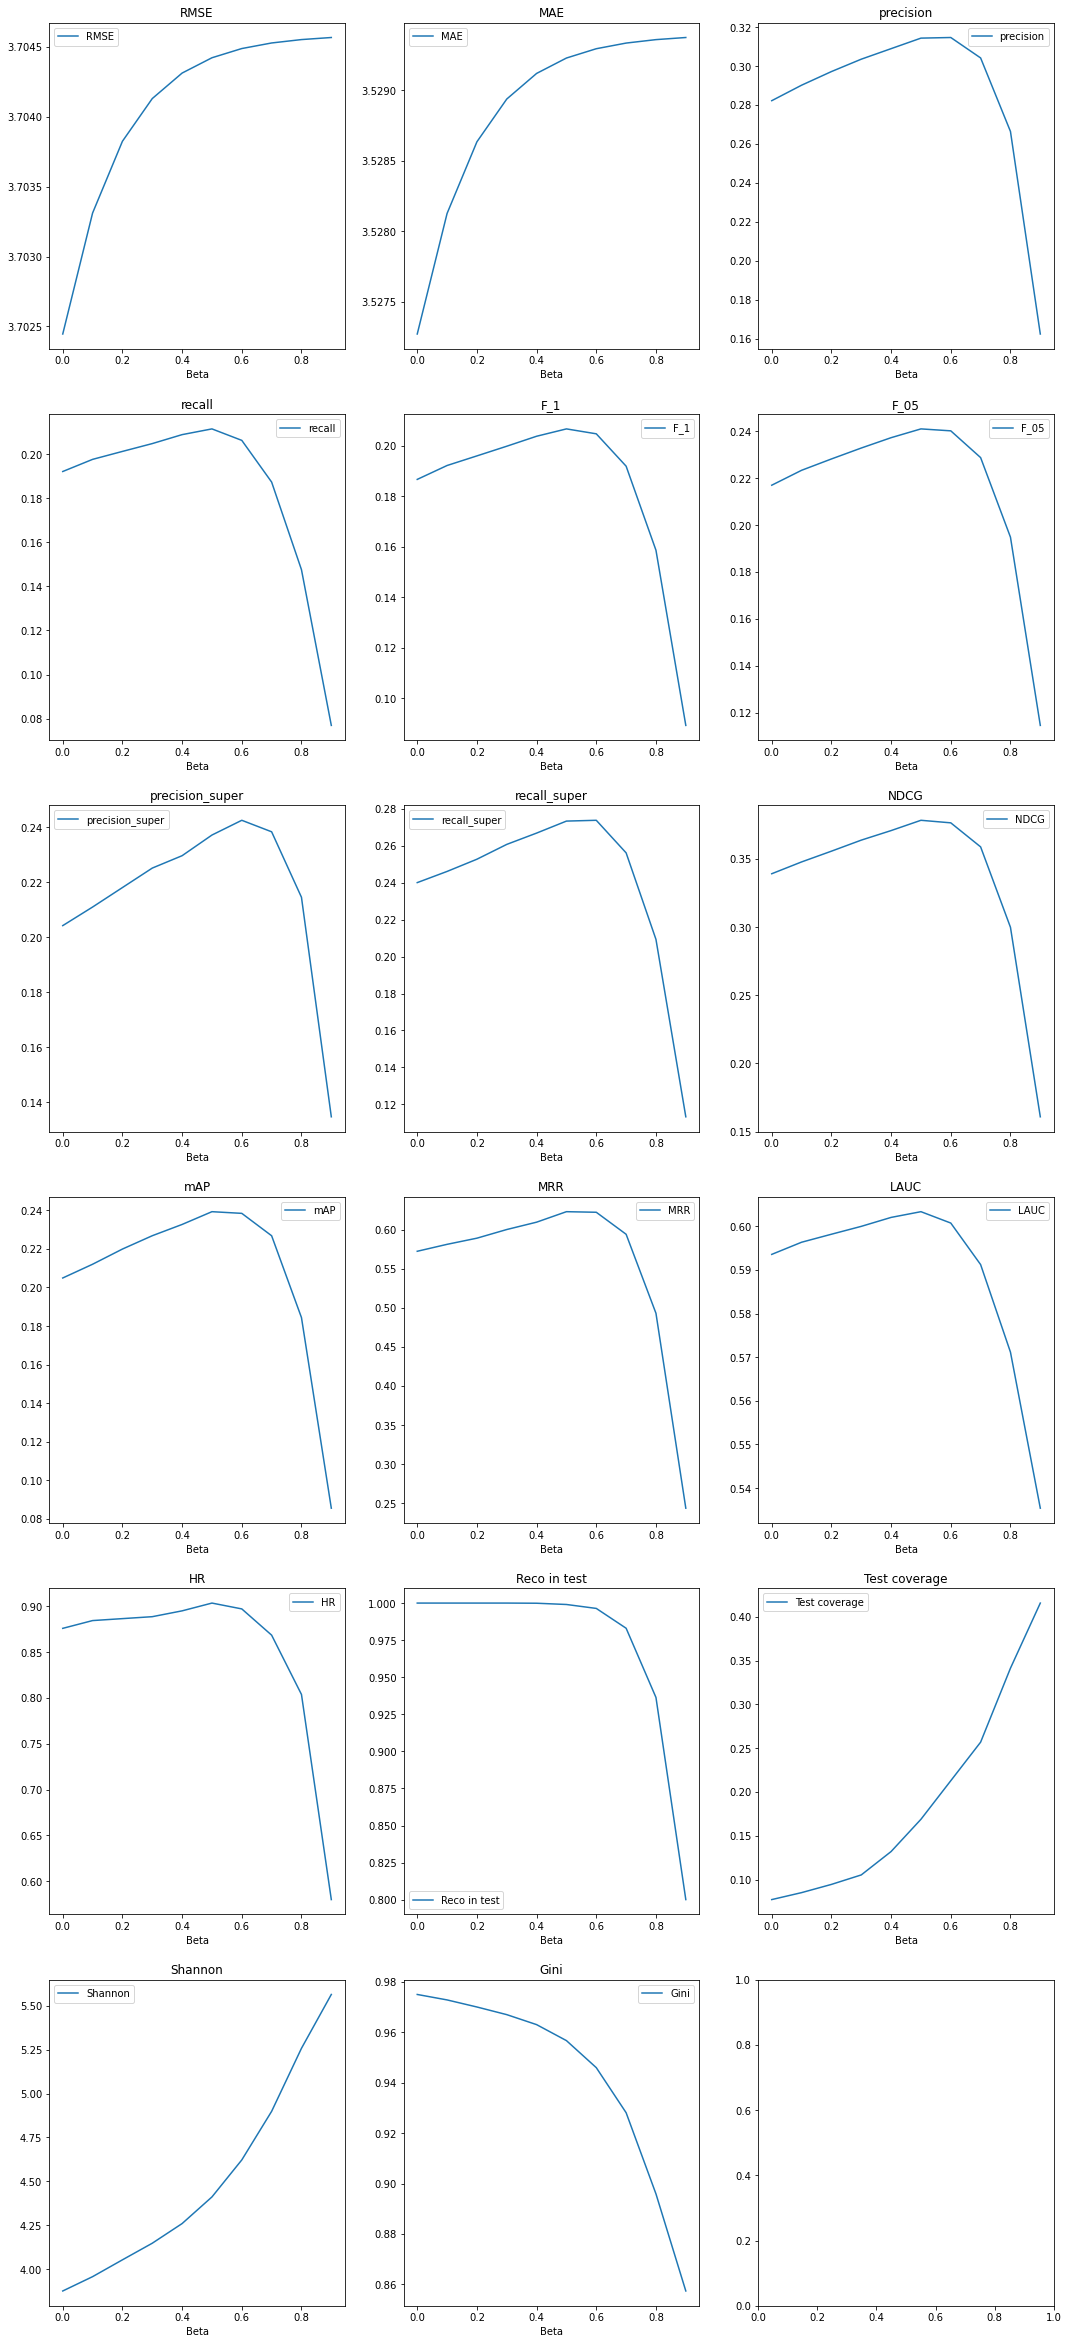

In [9]:
metrics = list(result.columns[[i not in ["Beta"] for i in result.columns]])

charts_per_row = 6
charts_per_column = 3

fig, axes = plt.subplots(
    nrows=charts_per_row, ncols=charts_per_column, figsize=(18, 7 * charts_per_row)
)
import itertools

to_iter = [
    i for i in itertools.product(range(charts_per_row), range(charts_per_column))
]

for i in range(len(metrics)):
    df = result[["Beta", metrics[i]]]
    df.plot(ax=axes[to_iter[i]], title=metrics[i], x=0, y=1)

# Check sample recommendations

In [10]:
train = pd.read_csv(
    "./Datasets/ml-100k/train.csv",
    sep="\t",
    header=None,
    names=["user", "item", "rating", "timestamp"],
)
items = pd.read_csv("./Datasets/ml-100k/movies.csv")

user = random.choice(list(set(train["user"])))

train_content = pd.merge(train, items, left_on="item", right_on="id")
display(
    train_content[train_content["user"] == user][
        ["user", "rating", "title", "genres"]
    ].sort_values(by="rating", ascending=False)[:15]
)

reco = np.loadtxt("Recommendations generated/ml-100k/Self_P3_reco.csv", delimiter=",")
items = pd.read_csv("./Datasets/ml-100k/movies.csv")

# Let's ignore scores - they are not used in evaluation:
reco_users = reco[:, :1]
reco_items = reco[:, 1::2]
# Let's put them into one array
reco = np.concatenate((reco_users, reco_items), axis=1)

# Let's rebuild it user-item dataframe
recommended = []
for row in reco:
    for rec_nb, entry in enumerate(row[1:]):
        recommended.append((row[0], rec_nb + 1, entry))
recommended = pd.DataFrame(recommended, columns=["user", "rec_nb", "item"])

recommended_content = pd.merge(recommended, items, left_on="item", right_on="id")
recommended_content[recommended_content["user"] == user][
    ["user", "rec_nb", "title", "genres"]
].sort_values(by="rec_nb")

user  rating                                          title  \
39675   599       5                      That Thing You Do! (1996)   
44133   599       5             Father of the Bride Part II (1995)   
55221   599       5                                Fan, The (1996)   
34957   599       5                My Best Friend's Wedding (1997)   
34654   599       5                                 Sabrina (1995)   
56202   599       5                           Happy Gilmore (1996)   
57099   599       5                   Up Close and Personal (1996)   
60181   599       5                         One Night Stand (1997)   
5385    599       5                           Jerry Maguire (1996)   
12546   599       5            Truth About Cats & Dogs, The (1996)   
9903    599       5                         Time to Kill, A (1996)   
8705    599       5         To Gillian on Her 37th Birthday (1996)   
63190   599       4                              Craft, The (1996)   
60634   599       4  Romy and Michele's High School Reunion (1997)   
63675   599       4                              Set It Off (1996)   

                genres  
39675           Comedy  
44133           Comedy  
55221         Thriller  
34957  Comedy, Romance  
34654  Comedy, Romance  
56202           Comedy  
57099   Drama, Romance  
60181            Drama  
5385    Drama, Romance  
12546  Comedy, Romance  
9903             Drama  
8705    Drama, Romance  
63190    Drama, Horror  
60634           Comedy  
63675    Action, Crime

user  rec_nb                          title  \
262   599.0       1               Star Wars (1977)   
7163  599.0       2                   Fargo (1996)   
2874  599.0       3      Return of the Jedi (1983)   
4627  599.0       4           Air Force One (1997)   
5873  599.0       5                 Contact (1997)   
8551  599.0       6  Independence Day (ID4) (1996)   
1189  599.0       7    English Patient, The (1996)   
8274  599.0       8      Mr. Holland's Opus (1995)   
7633  599.0       9               Rock, The (1996)   
2464  599.0      10          Godfather, The (1972)   

                                       genres  
262   Action, Adventure, Romance, Sci-Fi, War  
7163                   Crime, Drama, Thriller  
2874  Action, Adventure, Romance, Sci-Fi, War  
4627                         Action, Thriller  
5873                            Drama, Sci-Fi  
8551                      Action, Sci-Fi, War  
1189                      Drama, Romance, War  
8274                                    Drama  
7633              Action, Adventure, Thriller  
2464                     Action, Crime, Drama

# project task 5: generate recommendations of RP3Beta for hyperparameters found to optimize recall

In [11]:
# We generated recommendations for P3, a special case of RP3Beta (with alpha=1, beta=0).
# We've observed that changing alpha and beta impacts the model performance.

# Your task is find values alpha and beta for which recall will be the highest 
# (any solution with recall higher than P3 will be accepted)
# train the model and generate recommendations.

# save the outptut in 'Recommendations generated/ml-100k/Self_RP3Beta_estimations.csv'
# and 'Recommendations generated/ml-100k/Self_RP3Beta_reco.csv'

# project task 6 (optional): implement graph-based model of your choice 

In [12]:
# for example change length of paths in RP3beta or make some other modification (but change more than input and hyperparameters)
# feel free to implement your idea or search for some ideas

# save the outptut in 'Recommendations generated/ml-100k/Self_GraphTask_estimations.csv'
# and 'Recommendations generated/ml-100k/Self_GraphTask_reco.csv'